## Summary

L'objectif est de construire un modèle de classification capable de **prédire si une personne gagne plus ou moins de 50 000 dollars par an**, en utilisant ses caractéristiques socio-démographiques.

Le jeu de données est **"Adult Income"** du [UCI Machine Learning Repository](https://archive.ics.uci.edu/).

- **[UCIMLREPO](https://github.com/uci-ml-repo/ucimlrepo) package**

Le package UCIMLRepo (pour **UCI Machine Learning Repository**) est une **bibliothèque Python** qui facilite l’accès aux jeux de données disponibles sur le célèbre dépôt [UCI Machine Learning Repository](https://archive.ics.uci.edu/). Il permet de **chercher, télécharger et utiliser facilement ces datasets directement dans un notebook Python**, sans avoir à passer par un téléchargement manuel.

## Packages

In [1]:
pip install dill imblearn pendulum ucimlrepo yellowbrick

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install loguru

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 2.8 MB/s eta 0:00:00


In [2]:
from pathlib import Path

import dill
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import pendulum
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from imblearn.pipeline import Pipeline as imb_Pipeline
from loguru import logger
from sklearn import set_config
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix,
                             classification_report,
                             ConfusionMatrixDisplay,
                             roc_auc_score,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             RocCurveDisplay,
                             PrecisionRecallDisplay,
                            )
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder, OneHotEncoder
from ucimlrepo import fetch_ucirepo, list_available_datasets
from yellowbrick.classifier import DiscriminationThreshold

set_config(display='diagram')
pd.set_option("display.max_columns", None)

## Settings

In [3]:
EXECUTION_DATE = pendulum.now(tz="UTC")


ROOT_DIR = Path().cwd()
MODEL_DIR = Path(ROOT_DIR, "models")

MODEL_DIR.mkdir(parents=True, exist_ok=True)
logger.info(f"Model directory: {MODEL_DIR}")

2025-05-06 15:17:20.860 | INFO     | __main__:<module>:8 - Model directory: c:\Users\user\OneDrive\Desktop\ENSAE\Semestre 2\IML2\Tp_classification\tp-supervised-learning\models


## Data collection

In [5]:
# check which datasets can be imported
list_available_datasets()

-------------------------------------
The following datasets are available:
-------------------------------------
Dataset Name                                                                            ID    
------------                                                                            --    
Abalone                                                                                 1     
Adult                                                                                   2     
Annealing                                                                               3     
Audiology (Standardized)                                                                8     
Auto MPG                                                                                9     
Automobile                                                                              10    
Balance Scale                                                                           12    
Balloons                       

In [4]:
# fetch dataset
adult = fetch_ucirepo(name="Adult", id=None)

# fetch data
data = adult.data.original

logger.info(f"{data.shape}")

2025-05-06 15:17:52.438 | INFO     | __main__:<module>:7 - (48842, 15)


In [7]:
data.head()

age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0              13  United-States  <=50K  
2             0             0              40  United-States  <=50K  
3             0             0              40  United-States  <=50K  
4             0             0              40           Cuba  <=50K

In [8]:
# metadata
logger.info(f"Metadata \n {adult.metadata}")

# variable information
logger.info(f"Features: \n{adult.variables}")

2025-05-04 19:53:41.340 | INFO     | __main__:<cell line: 0>:2 - Metadata 
 {'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Cen

In [9]:
data.describe(include="all")

age workclass        fnlwgt education  education-num  \
count   48842.000000     47879  4.884200e+04     48842   48842.000000   
unique           NaN         9           NaN        16            NaN   
top              NaN   Private           NaN   HS-grad            NaN   
freq             NaN     33906           NaN     15784            NaN   
mean       38.643585       NaN  1.896641e+05       NaN      10.078089   
std        13.710510       NaN  1.056040e+05       NaN       2.570973   
min        17.000000       NaN  1.228500e+04       NaN       1.000000   
25%        28.000000       NaN  1.175505e+05       NaN       9.000000   
50%        37.000000       NaN  1.781445e+05       NaN      10.000000   
75%        48.000000       NaN  2.376420e+05       NaN      12.000000   
max        90.000000       NaN  1.490400e+06       NaN      16.000000   

            marital-status      occupation relationship   race    sex  \
count                48842           47876        48842  48842  48842   
unique                   7              15            6      5      2   
top     Married-civ-spouse  Prof-specialty      Husband  White   Male   
freq                 22379            6172        19716  41762  32650   
mean                   NaN             NaN          NaN    NaN    NaN   
std                    NaN             NaN          NaN    NaN    NaN   
min                    NaN             NaN          NaN    NaN    NaN   
25%                    NaN             NaN          NaN    NaN    NaN   
50%                    NaN             NaN          NaN    NaN    NaN   
75%                    NaN             NaN          NaN    NaN    NaN   
max                    NaN             NaN          NaN    NaN    NaN   

        capital-gain  capital-loss  hours-per-week native-country income  
count   48842.000000  48842.000000    48842.000000          48568  48842  
unique           NaN           NaN             NaN             42      4  
top              NaN           NaN             NaN  United-States  <=50K  
freq             NaN           NaN             NaN          43832  24720  
mean     1079.067626     87.502314       40.422382            NaN    NaN  
std      7452.019058    403.004552       12.391444            NaN    NaN  
min         0.000000      0.000000        1.000000            NaN    NaN  
25%         0.000000      0.000000       40.000000            NaN    NaN  
50%         0.000000      0.000000       40.000000            NaN    NaN  
75%         0.000000      0.000000       45.000000            NaN    NaN  
max     99999.000000   4356.000000       99.000000            NaN    NaN

In [19]:
data.columns = data.columns.str.replace("-", "_")
data.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income'],
      dtype='object')

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education_num   48842 non-null  int64 
 5   marital_status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital_gain    48842 non-null  int64 
 11  capital_loss    48842 non-null  int64 
 12  hours_per_week  48842 non-null  int64 
 13  native_country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


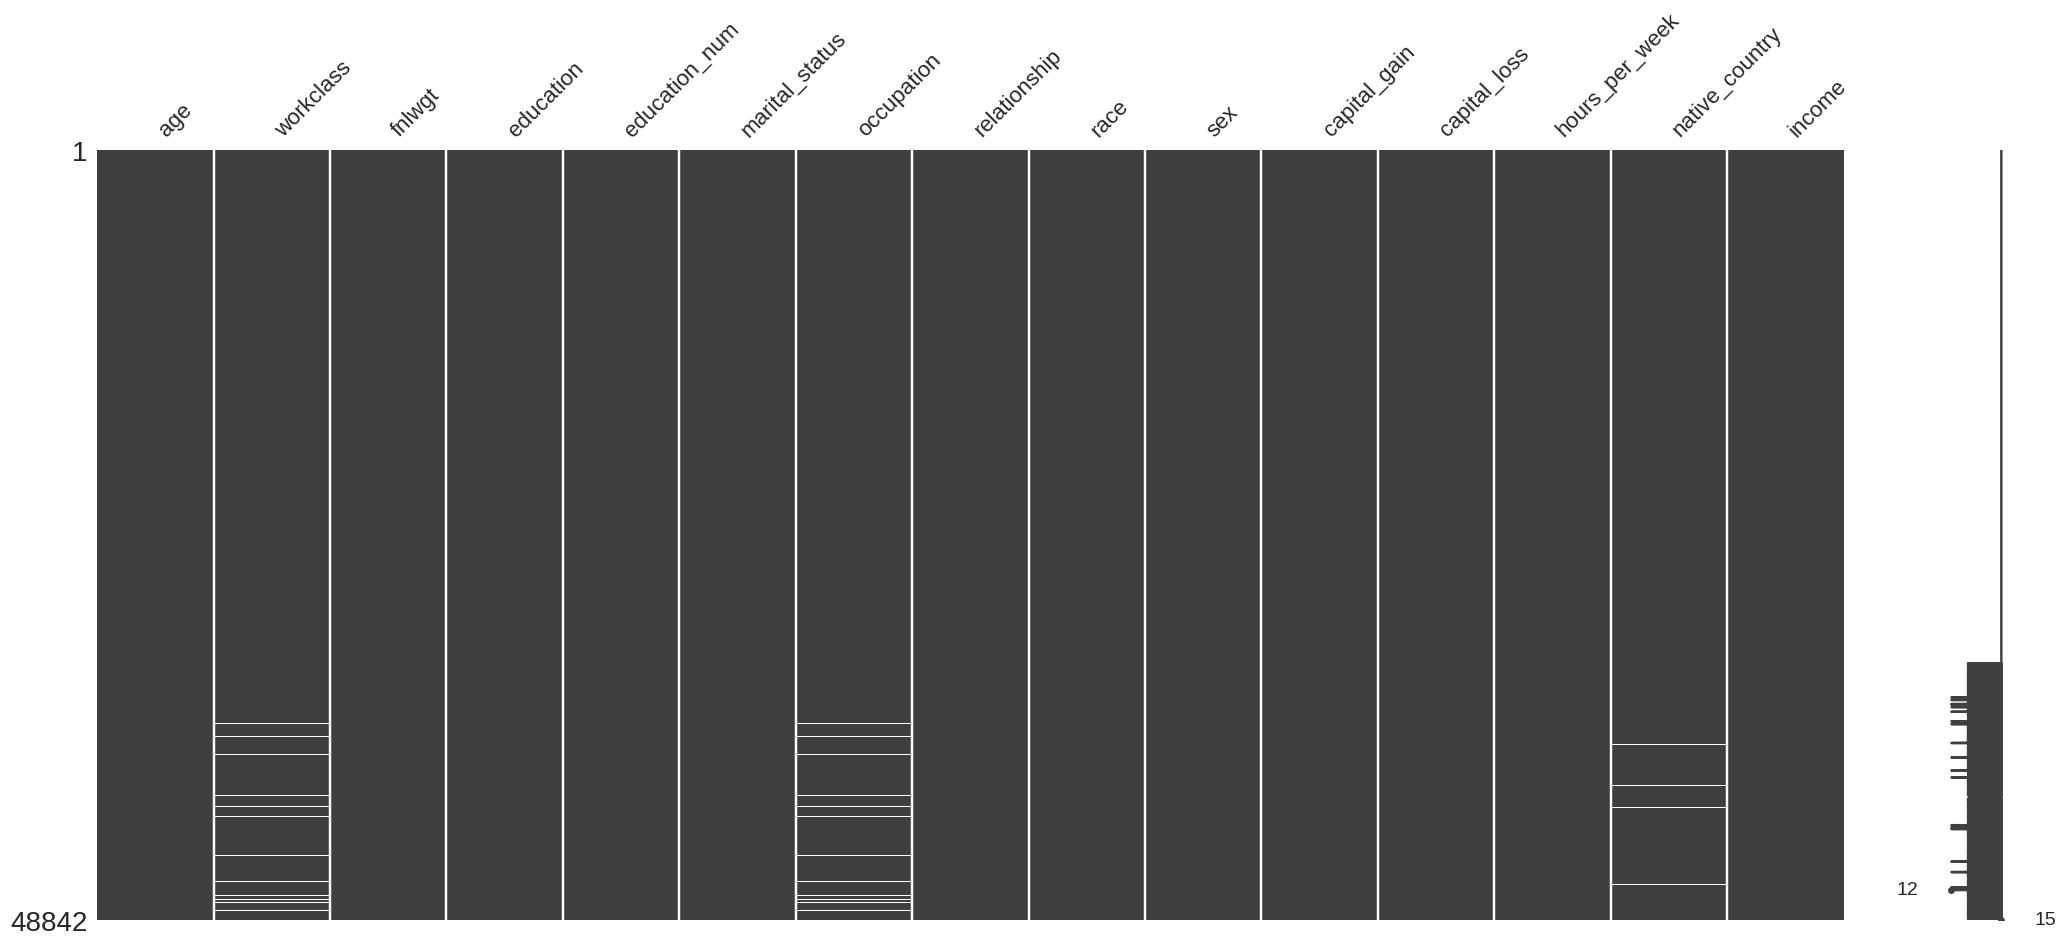

In [12]:
msno.matrix(data);

## EDA: Exploratory Data Analysis

In [5]:
data["income"].value_counts(normalize=False)

income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64

### Target

In [6]:
data = data.assign(income= lambda dfr: dfr.income.str.replace(".", ""))

In [7]:
label_distribution = data.groupby(['income']).size().reset_index(name='count')
label_distribution

income  count
0  <=50K  37155
1   >50K  11687

In [16]:
# Plot a pie chart with custom colors for income
fig = px.pie(
    label_distribution,
    names='income',  # Use 'income' for pie segments
    values='count',  # Use 'count' for the size of each pie slice
    # color='income',  # Color the segments based on income
    title='Income distribution',
    labels={'income': 'Income', 'count': 'Count'},
)

#fig.update_traces(textinfo='percent+label')  # Display percentage and labels on the pie chart

#fig.show()

### Categorical features

In [9]:
categorical_columns = data.select_dtypes(include="object").columns

categorical_columns

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country', 'income'],
      dtype='object')

In [10]:
for col_name in categorical_columns:
    logger.info(f"{col_name} ==============\n {data[col_name].value_counts(dropna=False)}\n")

2025-05-06 15:19:01.034 | INFO     | __main__:<module>:2 - workclass ==============
 workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
?                    1836
Self-emp-inc         1695
Federal-gov          1432
NaN                   963
Without-pay            21
Never-worked           10
Name: count, dtype: int64

2025-05-06 15:19:01.039 | INFO     | __main__:<module>:2 - education ==============
 education
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: count, dtype: int64

2025-05-06 15:19:01.043 | INFO     | __main__:<module>:2 - marital-status ==============
 marital-status
Married-civ-spouse       22379
Never-ma

#### Preprocessing

In [11]:
# Replace “?” with None for all columns containing it
data.replace("?", None, inplace=True)

In [20]:
msno.matrix(data);

### Remove Duplicated

In [21]:
# Shape after deduplication
data.shape

(48842, 15)

In [12]:
# Check for the duplicates: if True then there are duplicated
data.duplicated().any()

np.True_

In [13]:
data[data.duplicated(keep=False)].sort_values(["workclass", "education", "relationship"])

age workclass  fnlwgt     education  education-num marital-status  \
24667   17   Private  153021          12th              8  Never-married   
36713   17   Private  153021          12th              8  Never-married   
5842    25   Private  195994       1st-4th              2  Never-married   
13084   25   Private  195994       1st-4th              2  Never-married   
22300   25   Private  195994       1st-4th              2  Never-married   
...    ...       ...     ...           ...            ...            ...   
38993   22       NaN  334593  Some-college             10  Never-married   
10094   19      None  167428  Some-college             10  Never-married   
30384   20      None  203353  Some-college             10  Never-married   
34424   20       NaN  203353  Some-college             10  Never-married   
40677   19       NaN  167428  Some-college             10  Never-married   

            occupation   relationship   race     sex  capital-gain  \
24667            Sales      Own-child  White  Female             0   
36713            Sales      Own-child  White  Female             0   
5842   Priv-house-serv  Not-in-family  White  Female             0   
13084  Priv-house-serv  Not-in-family  White  Female             0   
22300  Priv-house-serv  Not-in-family  White  Female             0   
...                ...            ...    ...     ...           ...   
38993              NaN  Not-in-family  White    Male             0   
10094             None      Own-child  White    Male             0   
30384             None      Own-child  White  Female             0   
34424              NaN      Own-child  White  Female             0   
40677              NaN      Own-child  White    Male             0   

       capital-loss  hours-per-week native-country income  
24667             0              20  United-States  <=50K  
36713             0              20  United-States  <=50K  
5842              0              40      Guatemala  <=50K  
13084             0              40      Guatemala  <=50K  
22300             0              40      Guatemala  <=50K  
...             ...             ...            ...    ...  
38993             0              40  United-States  <=50K  
10094             0              40  United-States  <=50K  
30384             0              40  United-States  <=50K  
34424             0              40  United-States  <=50K  
40677             0              40  United-States  <=50K  

[101 rows x 15 columns]

In [16]:
# Drop duplicates
data = data.drop_duplicates(keep='first', inplace=False)
data.shape

(48790, 15)

In [17]:
# Shape after deduplication
data.shape

(48790, 15)

### Numerical features

In [20]:
data["capital_diff"] = data['capital_gain'] - data['capital_loss']

In [21]:
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

In [28]:
# Initialize a figure
fig = go.Figure()

# Iterate over numeric columns in the DataFrame
for column in numeric_columns:
    fig.add_trace(go.Box(
        y=data[column],
        name=column,
        marker=dict(color='skyblue')
    ))

# Update layout with a title and axis labels
fig.update_layout(
    title='Distribution of Numeric Columns without Outliers',
    yaxis_title='Values',
    xaxis_title='Numeric Columns'
)

# Show the figure
#fig.show()


In [29]:
n_cols = 3
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col_name in enumerate(numeric_columns):
    sns.histplot(data[col_name], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(col_name)

for i in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### Bivariate analysis

In [30]:
px.box(
    data,
    x='income',  # Income category on the x-axis
    y='age',  # Age distribution on the y-axis
    title='Age Distribution by Income',
    labels={'income': 'Income Category', 'age': 'Age'}
)

In [31]:
data

age         workclass  fnlwgt  education  education_num  \
0       39         State-gov   77516  Bachelors             13   
1       50  Self-emp-not-inc   83311  Bachelors             13   
2       38           Private  215646    HS-grad              9   
3       53           Private  234721       11th              7   
4       28           Private  338409  Bachelors             13   
...    ...               ...     ...        ...            ...   
48837   39           Private  215419  Bachelors             13   
48838   64               NaN  321403    HS-grad              9   
48839   38           Private  374983  Bachelors             13   
48840   44           Private   83891  Bachelors             13   
48841   35      Self-emp-inc  182148  Bachelors             13   

           marital_status         occupation    relationship  \
0           Never-married       Adm-clerical   Not-in-family   
1      Married-civ-spouse    Exec-managerial         Husband   
2                Divorced  Handlers-cleaners   Not-in-family   
3      Married-civ-spouse  Handlers-cleaners         Husband   
4      Married-civ-spouse     Prof-specialty            Wife   
...                   ...                ...             ...   
48837            Divorced     Prof-specialty   Not-in-family   
48838             Widowed                NaN  Other-relative   
48839  Married-civ-spouse     Prof-specialty         Husband   
48840            Divorced       Adm-clerical       Own-child   
48841  Married-civ-spouse    Exec-managerial         Husband   

                     race     sex  capital_gain  capital_loss  hours_per_week  \
0                   White    Male          2174             0              40   
1                   White    Male             0             0              13   
2                   White    Male             0             0              40   
3                   Black    Male             0             0              40   
4                   Black  Female             0             0              40   
...                   ...     ...           ...           ...             ...   
48837               White  Female             0             0              36   
48838               Black    Male             0             0              40   
48839               White    Male             0             0              50   
48840  Asian-Pac-Islander    Male          5455             0              40   
48841               White    Male             0             0              60   

      native_country income  capital_diff  
0      United-States  <=50K          2174  
1      United-States  <=50K             0  
2      United-States  <=50K             0  
3      United-States  <=50K             0  
4               Cuba  <=50K             0  
...              ...    ...           ...  
48837  United-States  <=50K             0  
48838  United-States  <=50K             0  
48839  United-States  <=50K             0  
48840  United-States  <=50K          5455  
48841  United-States   >50K             0  

[48790 rows x 16 columns]

In [32]:
for col_name in ["workclass",
                 "education",
                 "marital_status",
                 "sex"
                ]:

    feature_income_counts = data.groupby([col_name, 'income']).size().unstack()

    fig = px.bar(feature_income_counts,
                 barmode='stack',  # Stack bars for income categories
                 title=f'Relationship between Income and {col_name}',
                 labels={'value': 'Count'}
                )
    fig.show()

In [33]:
for col_name in numeric_columns:

    #counts
    num_feat_income_counts = data.groupby([col_name, "income"]).size().unstack()

    # Plot using iplot
    fig = px.area(num_feat_income_counts,
                  title=f"Relationship between {col_name} and income",
                  labels={"value": "Count"}
                 )
    fig.show()

In [34]:
sns.pairplot(data, hue="income", corner=True);

### Correlation

In [35]:
corr_matrix = data.loc[:, numeric_columns].corr()


In [36]:
data.loc[:, numeric_columns].corr()

age    fnlwgt  education_num  capital_gain  capital_loss  \
age             1.000000 -0.076451       0.030635      0.077185      0.056838   
fnlwgt         -0.076451  1.000000      -0.038727     -0.003715     -0.004378   
education_num   0.030635 -0.038727       1.000000      0.125219      0.080986   
capital_gain    0.077185 -0.003715       0.125219      1.000000     -0.031475   
capital_loss    0.056838 -0.004378       0.080986     -0.031475      1.000000   
hours_per_week  0.071223 -0.013521       0.143915      0.082152      0.054431   
capital_diff    0.073878 -0.003467       0.120459      0.998547     -0.085285   

                hours_per_week  capital_diff  
age                   0.071223      0.073878  
fnlwgt               -0.013521     -0.003467  
education_num         0.143915      0.120459  
capital_gain          0.082152      0.998547  
capital_loss          0.054431     -0.085285  
hours_per_week        1.000000      0.078959  
capital_diff          0.078959      1.000000

<Axes: >

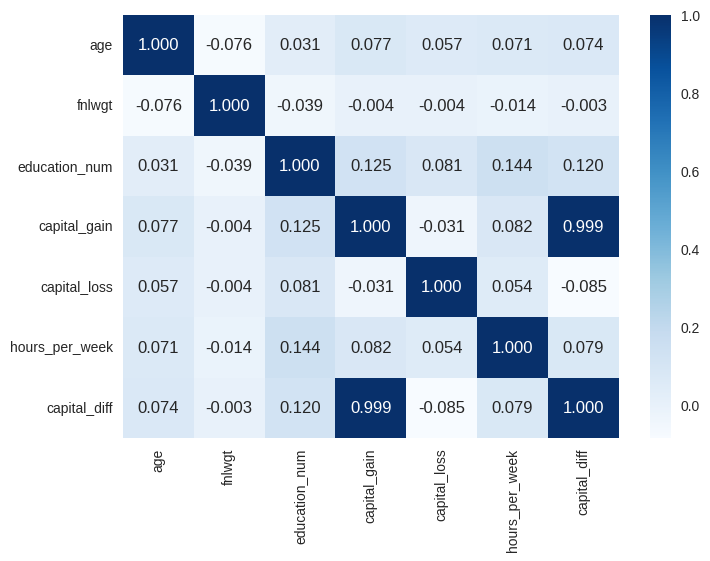

In [37]:
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap="Blues")

## Data preparation

In [38]:
data.head(100)
#data[[income]] = data.income.map({"<=50K.": 0, ">50K": 1})

age         workclass  fnlwgt     education  education_num  \
0    39         State-gov   77516     Bachelors             13   
1    50  Self-emp-not-inc   83311     Bachelors             13   
2    38           Private  215646       HS-grad              9   
3    53           Private  234721          11th              7   
4    28           Private  338409     Bachelors             13   
..  ...               ...     ...           ...            ...   
95   29         Local-gov  115585  Some-college             10   
96   48  Self-emp-not-inc  191277     Doctorate             16   
97   37           Private  202683  Some-college             10   
98   48           Private  171095    Assoc-acdm             12   
99   32       Federal-gov  249409       HS-grad              9   

        marital_status         occupation   relationship   race     sex  \
0        Never-married       Adm-clerical  Not-in-family  White    Male   
1   Married-civ-spouse    Exec-managerial        Husband  White    Male   
2             Divorced  Handlers-cleaners  Not-in-family  White    Male   
3   Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4   Married-civ-spouse     Prof-specialty           Wife  Black  Female   
..                 ...                ...            ...    ...     ...   
95       Never-married  Handlers-cleaners  Not-in-family  White    Male   
96  Married-civ-spouse     Prof-specialty        Husband  White    Male   
97  Married-civ-spouse              Sales        Husband  White    Male   
98            Divorced    Exec-managerial      Unmarried  White  Female   
99       Never-married      Other-service      Own-child  Black    Male   

    capital_gain  capital_loss  hours_per_week native_country income  \
0           2174             0              40  United-States  <=50K   
1              0             0              13  United-States  <=50K   
2              0             0              40  United-States  <=50K   
3              0             0              40  United-States  <=50K   
4              0             0              40           Cuba  <=50K   
..           ...           ...             ...            ...    ...   
95             0             0              50  United-States  <=50K   
96             0          1902              60  United-States   >50K   
97             0             0              48  United-States   >50K   
98             0             0              40        England  <=50K   
99             0             0              40  United-States  <=50K   

    capital_diff  
0           2174  
1              0  
2              0  
3              0  
4              0  
..           ...  
95             0  
96         -1902  
97             0  
98             0  
99             0  

[100 rows x 16 columns]

In [22]:
# Removing rows where 'Workclass' is 'Without-pay' and 'Never-worked'
data = data[~data["workclass"].str.lower().isin(["without-pay", "never-worked"])
            # & data["hours_per_week"].between(20, 60)
           ]
data.shape

(48759, 16)

In [23]:
data["hours_per_week"].value_counts(sort=False).sort_index()

hours_per_week
1      27
2      53
3      59
4      83
5      95
     ... 
95      2
96      9
97      2
98     14
99    137
Name: count, Length: 96, dtype: int64

In [24]:
#Feature mapping
workclass_mapping = {
    'Private': 'Private',
    'Self-emp-not-inc': 'Self-Employed',
    'Local-gov': 'Government',
    'State-gov': 'Government',
    'Self-emp-inc': 'Self-Employed',
    'Federal-gov': 'Government',
    'Without-pay': 'Other',
    'Never-worked': 'Other'
}

marital_status_mapping = {
    "Married-civ-spouse": "Married",
    "Married-spouse-absent": "Married",
    "Married-AF-spouse": "Married",
    "Separated": "Married",
    "Never-married": "Single",
    "Divorced": "Single",
    "Widowed": "Single"
}

relationship_mapping = {
    'Husband': 'spouse',
    'Not-in-family': 'Others:',
    'Own-child': 'Immediate Family',
    'Unmarried': 'Others:',
    'Wife': 'spouse',
    'Other-relative': 'Immediate Family',
}

# occupation
# occupation_mapping = to be defined if necessary

In [25]:
data = data.assign(income=lambda dfr: dfr['income'].map({"<=50K": 0, ">50K": 1}),
                   # capital_diff_bin = lambda dfr: pd.cut(dfr['capital_diff'], bins = [-5000, 5000, 100000], labels = ['Low', 'High'])
                   native_country=lambda dfr: dfr["native_country"].fillna("United-States").map(lambda val: val if val == "United-States" else "Others"),
                   education=lambda dfr: dfr.education.replace(["11th", "9th", "7th-8th", "5th-6th", "10th", "1st-4th", "12th"], "School"),
                   race=lambda dfr: dfr.race.map(lambda val: 'White' if val == 'White' else 'Others'),
                   # workclass=lambda dfr: dfr.workclass.map(workclass_mapping),
                   # marital_status=lambda dfr: dfr.marital_status.map(marital_status_mapping),
                   # relationship=lambda dfr: dfr.relationship.map(relationship_mapping),
                  )

## Train / test split

In [26]:
data.drop(['capital_gain',
           'capital_loss',
           "fnlwgt",  # fnlwgt (Final Weight): Represents the weight assigned to each individual.
           "education_num",
       ], axis=1, inplace=True)


In [27]:
x_values = data.drop(columns=['income'])
y_target = data.income

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x_values, y_target, test_size=0.2, random_state=42, stratify=y_target)

In [46]:
x_train.head()

age         workclass     education      marital_status  \
44101   35         Local-gov     Bachelors  Married-civ-spouse   
36845   61           Private       HS-grad            Divorced   
44706   41           Private  Some-college            Divorced   
35127   49  Self-emp-not-inc        School  Married-civ-spouse   
41678   37  Self-emp-not-inc     Assoc-voc  Married-civ-spouse   

              occupation   relationship   race     sex  hours_per_week  \
44101    Protective-serv        Husband  White    Male              48   
36845  Machine-op-inspct  Not-in-family  White  Female              40   
44706              Sales      Unmarried  White    Male              46   
35127    Farming-fishing        Husband  White    Male              50   
41678    Farming-fishing        Husband  White    Male              60   

      native_country  capital_diff  
44101  United-States             0  
36845  United-States             0  
44706  United-States             0  
35127  United-States             0  
41678  United-States             0

In [29]:
y_train.value_counts(normalize=True).mul(100).round(2)

income
0    76.05
1    23.95
Name: proportion, dtype: float64

In [30]:
y_train.value_counts(normalize=True).mul(100).round(2)

income
0    76.05
1    23.95
Name: proportion, dtype: float64

### Feature engineering

In [49]:
x_values.head()

age         workclass  education      marital_status         occupation  \
0   39         State-gov  Bachelors       Never-married       Adm-clerical   
1   50  Self-emp-not-inc  Bachelors  Married-civ-spouse    Exec-managerial   
2   38           Private    HS-grad            Divorced  Handlers-cleaners   
3   53           Private     School  Married-civ-spouse  Handlers-cleaners   
4   28           Private  Bachelors  Married-civ-spouse     Prof-specialty   

    relationship    race     sex  hours_per_week native_country  capital_diff  
0  Not-in-family   White    Male              40  United-States          2174  
1        Husband   White    Male              13  United-States             0  
2  Not-in-family   White    Male              40  United-States             0  
3        Husband  Others    Male              40  United-States             0  
4           Wife  Others  Female              40         Others             0

In [31]:
# numerical
numeric_features = x_values.select_dtypes(include="number").columns

# categorical
onehot_features = ['workclass', 'occupation', 'relationship', 'race', 'sex', 'marital_status']

country_feature = ["native_country"]
ordinal_features = ['education',
                   # 'capital_diff_bin',
                  ]

cat_for_edu = ['Preschool', 'School', 'HS-grad','Some-college', 'Assoc-voc', 'Assoc-acdm','Bachelors', 'Masters', 'Prof-school', 'Doctorate']
cat_for_capdiff = ['Low', 'High']

In [32]:
x_train.loc[:, numeric_features]

age  hours_per_week  capital_diff
44101   35              48             0
36845   61              40             0
44706   41              46             0
35127   49              50             0
41678   37              60             0
...    ...             ...           ...
2324    63              50             0
30520   21              40             0
42196   60              25             0
41858   34              40             0
26127   19              35             0

[39007 rows x 3 columns]

In [33]:
x_train.loc[:, numeric_features]

age  hours_per_week  capital_diff
44101   35              48             0
36845   61              40             0
44706   41              46             0
35127   49              50             0
41678   37              60             0
...    ...             ...           ...
2324    63              50             0
30520   21              40             0
42196   60              25             0
41858   34              40             0
26127   19              35             0

[39007 rows x 3 columns]

In [34]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


# Education : ordinal + imputation 'undefined' gérée via catégorie manquante
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='undefined')),
    ('ordinal', OrdinalEncoder(categories=[cat_for_edu + ['undefined']], handle_unknown='use_encoded_value', unknown_value=-1))
])

# OneHot : autres variables catégorielles avec imputation "undefined"
onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='undefined')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Native country : imputation avec "United-States"
country_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='United-States')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('ord', ordinal_transformer, ordinal_features),
    ('cat', onehot_transformer, onehot_features),
    ('country', country_transformer, country_feature)
])



preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 Index(['age', 'hours_per_week', 'capital_diff'], dtype='object')),
                                ('ord',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='undefined',
                                                                strategy='constant')),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['Preschool',
                                                                              'School',
                                                                              'HS-...
                                                  SimpleImputer(fill_value='undefined',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['workclass', 'occupation', 'relationship',
                                  'race', 'sex', 'marital_status']),
                                ('country',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='United-States',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['native_country'])])

## Modeling

#### Dummy regressor

In [54]:
# Pipeline
dm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', DummyClassifier())
])

dm_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hours_per_week', 'capital_diff'], dtype='object')),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='undefined',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(catego...
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass', 'occupation',
                                                   'relationship', 'race',
                                                   'sex', 'marital_status']),
                                                 ('country',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='United-States',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['native_country'])])),
                ('clf', DummyClassifier())])

In [55]:
# Training
dm_pipeline.fit(x_train, y_train)

# Predictions & evaluation
dm_y_pred_test = dm_pipeline.predict(x_test)
dm_y_proba_test = dm_pipeline.predict_proba(x_test)[:, 1]


logger.info(f"AUC: {roc_auc_score(y_test, dm_y_proba_test):.2f}")

logger.info(f"Classification report: \n{classification_report(y_test, dm_y_pred_test)}")

2025-05-04 19:56:01.142 | INFO     | __main__:<cell line: 0>:9 - AUC: 0.50
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

2025-05-04 19:56:01.157 | INFO     | __main__:<cell line: 0>:11 - Classification report: 
              precision    recall  f1-score   support

           0       0.76      1.00      0.8

#### Logistic regression

In [56]:
# Pipeline
rl_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])

rl_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hours_per_week', 'capital_diff'], dtype='object')),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='undefined',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(catego...
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass', 'occupation',
                                                   'relationship', 'race',
                                                   'sex', 'marital_status']),
                                                 ('country',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='United-States',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['native_country'])])),
                ('clf', LogisticRegression(max_iter=1000))])

##### Baseline

In [57]:
# 8. Entraînement
rl_pipeline.fit(x_train, y_train)

# 9. Prédictions & évaluation
rl_y_pred_test = rl_pipeline.predict(x_test)
rl_y_proba_test = rl_pipeline.predict_proba(x_test)[:, 1]


logger.info(f"AUC: {roc_auc_score(y_test, rl_y_proba_test):.2f} ")

logger.info(f"Classification report: \n{classification_report(y_test, rl_y_pred_test)}")

2025-05-04 19:56:01.908 | INFO     | __main__:<cell line: 0>:9 - AUC: 0.90 
2025-05-04 19:56:01.922 | INFO     | __main__:<cell line: 0>:11 - Classification report: 
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      7416
           1       0.72      0.59      0.65      2336

    accuracy                           0.85      9752
   macro avg       0.80      0.76      0.78      9752
weighted avg       0.84      0.85      0.84      9752



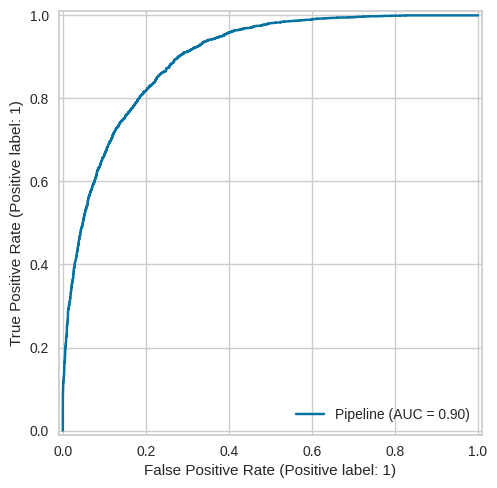

In [58]:
RocCurveDisplay.from_estimator(rl_pipeline, x_test, y_test);

In [59]:
PrecisionRecallDisplay.from_estimator(rl_pipeline, x_test, y_test);


##### Tuning hyperparameters

In [60]:
rl_param_grid = {
    "clf__penalty": ["l2"],  # 'l1' si solver = 'liblinear' ou 'saga'
    "clf__C": [0.01, 0.1, 1, 2, 3, 5, 10],
    "clf__solver": ['liblinear', 'lbfgs', "sag", "saga"],  # lbfgs ne supporte que l2
    "clf__class_weight": ['balanced', None],
}

In [61]:
# Cross-validation
cv = StratifiedKFold(n_splits=5)

rl_grid_search = GridSearchCV(rl_pipeline, rl_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)

# Training
rl_grid_search.fit(x_train, y_train)

# Best params
logger.info(f"Best params : {rl_grid_search.best_params_}")

# Evaluation
rl_y_pred_test_opt = rl_grid_search.predict(x_test)
rl_y_proba_test_opt  = rl_grid_search.predict_proba(x_test)[:, 1]

logger.info(f"AUC : {roc_auc_score(y_test, rl_y_proba_test_opt):.2f}")
logger.info(f"F1-score : {f1_score(y_test, rl_y_pred_test_opt):.2f}")
logger.info(f"Accuracy : {accuracy_score(y_test, rl_y_pred_test_opt):.2f}")


2025-05-04 20:07:51.320 | INFO     | __main__:<cell line: 0>:10 - Best params : {'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
2025-05-04 20:07:51.473 | INFO     | __main__:<cell line: 0>:16 - AUC : 0.90
2025-05-04 20:07:51.481 | INFO     | __main__:<cell line: 0>:17 - F1-score : 0.66
2025-05-04 20:07:51.486 | INFO     | __main__:<cell line: 0>:18 - Accuracy : 0.79


##### Discrimination threshold

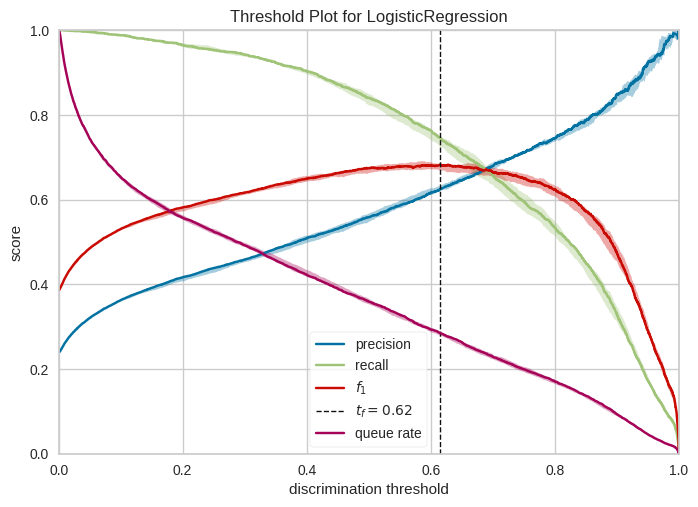

In [62]:
viz = DiscriminationThreshold(rl_grid_search.best_estimator_, random_state=42, fbeta=1.0, cv=cv, argmax="fscore")

# Fit et plot
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.show();

In [63]:
data_lift = pd.DataFrame({"y_true": y_test, "y_pred": rl_y_pred_test_opt, "proba": rl_y_proba_test_opt})
data_lift = data_lift.sort_values("proba", ascending=False).reset_index(drop=True)
data_lift.head()

y_true  y_pred  proba
0       1       1    1.0
1       1       1    1.0
2       1       1    1.0
3       1       1    1.0
4       1       1    1.0

In [64]:
data_lift["decile"] = pd.qcut(data_lift.index, 10, labels=False)
data_lift.head()

y_true  y_pred  proba  decile
0       1       1    1.0       0
1       1       1    1.0       0
2       1       1    1.0       0
3       1       1    1.0       0
4       1       1    1.0       0

In [65]:
# Global positive rate
global_positive_rate =  data_lift["y_true"].sum() / len(data_lift)
global_positive_rate

np.float64(0.23954060705496308)

In [66]:
lift_aggregate_table = data_lift.groupby("decile")["y_true"].agg(["sum", "count"])

In [67]:
lift_aggregate_table["cum_positives"] = lift_aggregate_table["sum"].cumsum()

lift_aggregate_table["positive_rate_cum"] = lift_aggregate_table["cum_positives"] / lift_aggregate_table["count"].cumsum()
lift_aggregate_table["lift_score"] = lift_aggregate_table["positive_rate_cum"] / global_positive_rate

In [68]:
lift_aggregate_table["percent_sample"] = 10 * (lift_aggregate_table.index + 1)


In [69]:
lift_aggregate_table
px.line(
    lift_aggregate_table,
    x="percent_sample",
    y="lift_score",
    labels={
        "percent_sample": "Cumulative % of Sample",
        "lift_score": "Lift Score"
    },
    title="Lift Curve"
)

In [70]:
best =0.75
logger.info(f"Best threshold: {best:.2f}", "classification")
logger.info(f"Best threshold: {best:.2f}", "classification")
logger.info(f"Best threshold: {best:.2f}", "classification")
print(classification_report(y_test, rl_y_pred_test_opt, target_names=["<=50K", ">50K"]))
print(confusion_matrix(y_test, rl_y_pred_test_opt, labels=[0, 1]))

2025-05-04 20:11:09.002 | INFO     | __main__:<cell line: 0>:2 - Best threshold: 0.75
2025-05-04 20:11:09.004 | INFO     | __main__:<cell line: 0>:3 - Best threshold: 0.75
2025-05-04 20:11:09.005 | INFO     | __main__:<cell line: 0>:4 - Best threshold: 0.75


              precision    recall  f1-score   support

       <=50K       0.94      0.78      0.85      7416
        >50K       0.55      0.84      0.66      2336

    accuracy                           0.79      9752
   macro avg       0.74      0.81      0.76      9752
weighted avg       0.85      0.79      0.81      9752

[[5785 1631]
 [ 370 1966]]


##### Model analysis

In [71]:
# features importances

##### Save model

In [72]:
# Save model

model_path_name = Path(MODEL_DIR, "best_logistic_model.dill")

logger.info(f"Model path name: {model_path_name}")
with open(model_path_name, "wb") as fp:
    dill.dump(rl_grid_search.best_estimator_, fp)

2025-05-04 20:11:09.030 | INFO     | __main__:<cell line: 0>:5 - Model path name: /content/models/best_logistic_model.dill


### KNN

#### Baseline

In [73]:
# Pipeline
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', KNeighborsClassifier(n_neighbors=10))
])

knn_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hours_per_week', 'capital_diff'], dtype='object')),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='undefined',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(catego...
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass', 'occupation',
                                                   'relationship', 'race',
                                                   'sex', 'marital_status']),
                                                 ('country',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='United-States',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['native_country'])])),
                ('clf', KNeighborsClassifier(n_neighbors=10))])

In [74]:
# 8. Entraînement
knn_pipeline.fit(x_train, y_train)

# 9. Prédictions & évaluation
knn_y_pred_test = knn_pipeline.predict(x_test)
knn_y_proba_test = knn_pipeline.predict_proba(x_test)[:, 1]


logger.info(f"AUC: {roc_auc_score(y_test, knn_y_proba_test):.2f}")

logger.info(f"Classification report: \n{classification_report(y_test, knn_y_pred_test)}")

2025-05-04 20:11:52.021 | INFO     | __main__:<cell line: 0>:9 - AUC: 0.88
2025-05-04 20:11:52.036 | INFO     | __main__:<cell line: 0>:11 - Classification report: 
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      7416
           1       0.73      0.56      0.63      2336

    accuracy                           0.84      9752
   macro avg       0.80      0.75      0.77      9752
weighted avg       0.84      0.84      0.84      9752



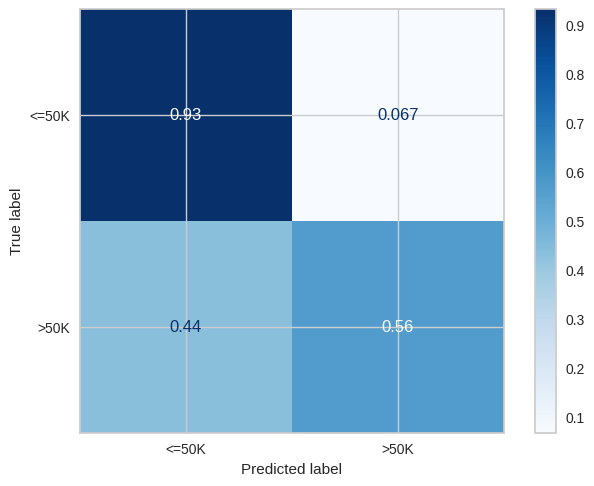

In [75]:
ConfusionMatrixDisplay.from_estimator(knn_pipeline, x_test, y_test,
                                      display_labels=["<=50K", ">50K"],
                                      normalize="true", cmap=plt.cm.Blues);

In [76]:
RocCurveDisplay.from_estimator(knn_pipeline, x_test, y_test);

In [77]:
cv = StratifiedKFold(n_splits=5)

# Define parameter grid for KNeighborsClassifier
knn_param_grid = {
    "clf__n_neighbors": [3, 5, 10, 15],
    "clf__weights": ["uniform", "distance"],
    "clf__metric": ["euclidean", "manhattan", "minkowski"]
}

# GridSearchCV for KNN pipeline
knn_grid_search = GridSearchCV(knn_pipeline, knn_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)

# Training
knn_grid_search.fit(x_train, y_train)

# Best params
logger.info(f"Best params : {knn_grid_search.best_params_}")

# Evaluation
knn_y_pred_test_opt = knn_grid_search.predict(x_test)
knn_y_proba_test_opt = knn_grid_search.predict_proba(x_test)[:, 1]

logger.info(f"AUC : {roc_auc_score(y_test, knn_y_proba_test_opt):.2f}")
logger.info(f"F1-score : {f1_score(y_test, knn_y_pred_test_opt):.2f}")
logger.info(f"Accuracy : {accuracy_score(y_test, knn_y_pred_test_opt):.2f}")

2025-05-04 20:36:25.451 | INFO     | __main__:<cell line: 0>:17 - Best params : {'clf__metric': 'euclidean', 'clf__n_neighbors': 15, 'clf__weights': 'uniform'}
2025-05-04 20:37:01.465 | INFO     | __main__:<cell line: 0>:23 - AUC : 0.89
2025-05-04 20:37:01.472 | INFO     | __main__:<cell line: 0>:24 - F1-score : 0.66
2025-05-04 20:37:01.474 | INFO     | __main__:<cell line: 0>:25 - Accuracy : 0.85


In [78]:
# Training
knn_grid_search.fit(x_train, y_train)

# Best params
logger.info(f"Best params : \n{knn_grid_search.best_params_}")

# Evaluation
best_treshold = 0.66
knn_y_proba_test_opt = knn_grid_search.predict_proba(x_test)[:, 1]
knn_y_pred_test_opt = (knn_y_proba_test_opt >= best_treshold).astype(int)

logger.info(f"AUC : {roc_auc_score(y_test, knn_y_proba_test_opt):.2f}")
logger.info(f"F1-score : {f1_score(y_test, knn_y_pred_test_opt):.2f}")
logger.info(f"Accuracy : {accuracy_score(y_test, knn_y_pred_test_opt):.2f}")

2025-05-04 21:00:55.584 | INFO     | __main__:<cell line: 0>:5 - Best params : 
{'clf__metric': 'euclidean', 'clf__n_neighbors': 15, 'clf__weights': 'uniform'}
2025-05-04 21:01:13.557 | INFO     | __main__:<cell line: 0>:12 - AUC : 0.89
2025-05-04 21:01:13.564 | INFO     | __main__:<cell line: 0>:13 - F1-score : 0.58
2025-05-04 21:01:13.567 | INFO     | __main__:<cell line: 0>:14 - Accuracy : 0.84


## Todo

- Entrainer / optimiser 2 modèles ensemblistes
- Choisir le meilleur modèle parmi tous ceux qu'on a entrainé
- Etudier le feature importance global et local avec `shap`
- Optimiser si besoin le modèle et l'enregistrer au format `.dill`

- `Deadline`: mardi 06/05/2025 à 18h
-  `Email` : mouslydiaw@gmail.com
-  `Objet` : TP ISE - classification 2025

# TP de Machine Learning

## 1. Entrainer et optimisons 2 modèles ensemblistes

### 1- Random Forest


Random Forest construit plusieurs arbres de décision (estimators) sur des sous-échantillons différents des données, puis agrège leurs prédictions :

- En classification : par vote majoritaire.
- En régression : par moyenne des prédictions.
Bagging (Bootstrap Aggregating) :

Chaque arbre est entraîné sur un échantillon aléatoire avec remplacement des données (bootstrap).

Cela réduit la variance par rapport à un arbre unique (qui est très sensible aux fluctuations des données).

Randomisation des variables :

À chaque nœud de chaque arbre, seule une sous-partie aléatoire des variables est utilisée pour chercher la meilleure séparation.

Cela permet de diversifier les arbres et éviter la corrélation entre eux.

Avantages :
Moins sensible au surapprentissage (overfitting) qu’un seul arbre.

- Gère bien les variables bruitées ou non pertinentes.

- Fonctionne bien sans beaucoup de réglages.

In [79]:
from sklearn.ensemble import RandomForestClassifier
# Pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])

rf_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hours_per_week', 'capital_diff'], dtype='object')),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='undefined',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(catego...
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass', 'occupation',
                                                   'relationship', 'race',
                                                   'sex', 'marital_status']),
                                                 ('country',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='United-States',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['native_country'])])),
                ('clf', RandomForestClassifier(random_state=42))])

In [80]:
# 8. Entraînement
rf_pipeline.fit(x_train, y_train)

# 9. Prédictions & évaluation
rf_y_pred_test = rf_pipeline.predict(x_test)
rf_y_proba_test = rf_pipeline.predict_proba(x_test)[:, 1]


logger.info(f"AUC: {roc_auc_score(y_test, rf_y_proba_test):.2f}")

logger.info(f"Classification report: \n{classification_report(y_test, rf_y_pred_test)}")

2025-05-04 21:01:59.938 | INFO     | __main__:<cell line: 0>:9 - AUC: 0.89
2025-05-04 21:01:59.950 | INFO     | __main__:<cell line: 0>:11 - Classification report: 
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      7416
           1       0.70      0.63      0.66      2336

    accuracy                           0.85      9752
   macro avg       0.79      0.77      0.78      9752
weighted avg       0.84      0.85      0.84      9752



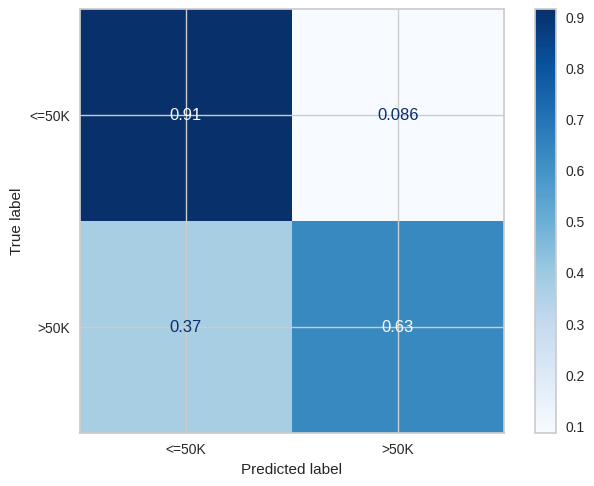

In [81]:
ConfusionMatrixDisplay.from_estimator(rf_pipeline, x_test, y_test,
                                      display_labels=["<=50K", ">50K"],
                                      normalize="true", cmap=plt.cm.Blues);

In [82]:
RocCurveDisplay.from_estimator(rf_pipeline, x_test, y_test);

## Tunning des paramètres


In [83]:
# Define parameter grid for RandomForestClassifier
rf_param_grid = {
    "clf__n_estimators": [100, 200, 300],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", "log2"]
}

In [84]:
from scipy.stats import randint
param_distributions={
        "clf__n_estimators": randint(100, 300),
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_split": [2, 5, 10],
        "clf__min_samples_leaf": [1, 2],
        "clf__max_features": ["sqrt", "log2"]
    }

In [85]:
from sklearn.model_selection import RandomizedSearchCV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Recherche aléatoire
rf_random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_distributions,
    n_iter=20,  # nombre de combinaisons testées
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Entraînement
rf_random_search.fit(x_train, y_train)

# Meilleurs hyperparamètres
logger.info(f"Best parameters: {rf_random_search.best_params_}")

# Prédictions
rf_y_pred = rf_random_search.predict(x_test)
rf_y_proba = rf_random_search.predict_proba(x_test)[:, 1]

# Évaluation
logger.info(f"AUC: {roc_auc_score(y_test, rf_y_proba):.2f}")
logger.info(f"F1-score: {f1_score(y_test, rf_y_pred):.2f}")
logger.info(f"Accuracy: {accuracy_score(y_test, rf_y_pred):.2f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits


2025-05-04 21:17:58.203 | INFO     | __main__:<cell line: 0>:20 - Best parameters: {'clf__max_depth': 20, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 10, 'clf__n_estimators': 289}
2025-05-04 21:17:59.098 | INFO     | __main__:<cell line: 0>:27 - AUC: 0.92
2025-05-04 21:17:59.105 | INFO     | __main__:<cell line: 0>:28 - F1-score: 0.69
2025-05-04 21:17:59.107 | INFO     | __main__:<cell line: 0>:29 - Accuracy: 0.86


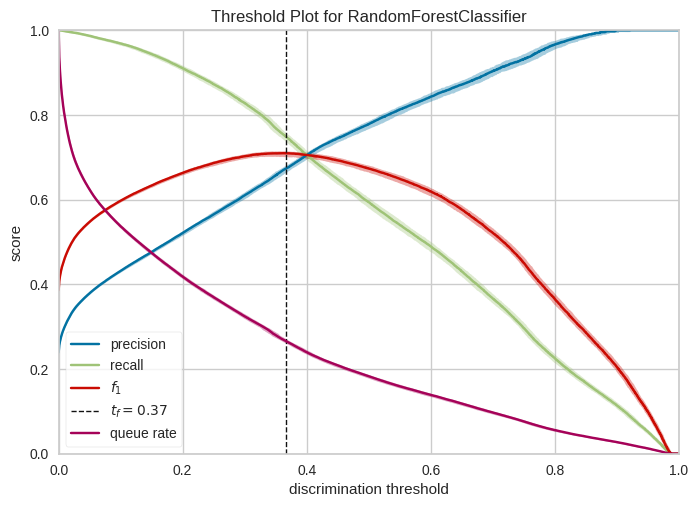

In [103]:
viz = DiscriminationThreshold(rf_random_search.best_estimator_, random_state=42, fbeta=1.0, cv=cv, argmax="fscore")

# Fit et plot
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.show();

In [109]:
data_lift = pd.DataFrame({"y_true": y_test, "y_pred": rf_y_pred, "proba": rf_y_proba})
data_lift = data_lift.sort_values("proba", ascending=False).reset_index(drop=True)
data_lift.head()

y_true  y_pred     proba
0       1       1  0.992177
1       1       1  0.992170
2       1       1  0.992169
3       1       1  0.991474
4       1       1  0.991247

In [106]:
data_lift["decile"] = pd.qcut(data_lift.index, 10, labels=False)
data_lift.head()

y_true  y_pred     proba  decile
0       1       1  0.992177       0
1       1       1  0.992170       0
2       1       1  0.992169       0
3       1       1  0.991474       0
4       1       1  0.991247       0

In [86]:
ConfusionMatrixDisplay.from_estimator(rf_random_search, x_test, y_test,
                                      display_labels=["<=50K", ">50K"],
                                      normalize="true", cmap=plt.cm.Blues);

In [87]:
RocCurveDisplay.from_estimator(rf_random_search, x_test, y_test);

## 2. XGboost

XGBoost (eXtreme Gradient Boosting) est un algorithme de machine learning supervisé destiné à produire des modèles puissants de classification ou de régression, avec des performances rapides et précises.

Il est particulièrement connu pour :

--Sa vitesse,

- Sa précision,

- capacité à gérer les grands jeux de données.

Elle consiste à construire un modèle fort en combinant plusieurs modèles faibles (typiquement des arbres de décision) de manière séquentielle.

À chaque étape :

Un nouvel arbre est entraîné pour corriger les erreurs du modèle précédent.

Cela se fait en minimisant une fonction de perte via la descente de gradient.


In [38]:

from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

xgb_pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hours_per_week', 'capital_diff'], dtype='object')),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='undefined',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(catego...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [39]:
# 8. Entraînement
xgb_pipeline.fit(x_train, y_train)

# 9. Prédictions & évaluation
xgb_y_pred_test = xgb_pipeline.predict(x_test)
xgb_y_proba_test =xgb_pipeline.predict_proba(x_test)[:, 1]


logger.info(f"AUC: {roc_auc_score(y_test, xgb_y_proba_test):.2f}")

logger.info(f"Classification report: \n{classification_report(y_test,xgb_y_pred_test)}")

c:\Users\user\OneDrive\Desktop\ENSAE\Semestre 2\IML2\Tp_classification\tp-supervised-learning\.env\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2025-05-06 15:39:26.072 | INFO     | __main__:<module>:9 - AUC: 0.93
2025-05-06 15:39:26.107 | INFO     | __main__:<module>:11 - Classification report: 
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7416
           1       0.77      0.68      0.72      2336

    accuracy                           0.87      9752
   macro avg       0.84      0.81      0.82      9752
weighted avg       0.87      0.87      0.87      9752



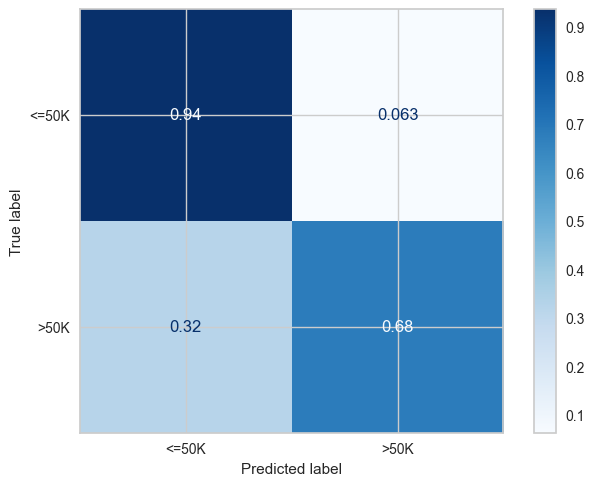

In [40]:
ConfusionMatrixDisplay.from_estimator(xgb_pipeline, x_test, y_test,
                                      display_labels=["<=50K", ">50K"],
                                      normalize="true", cmap=plt.cm.Blues);

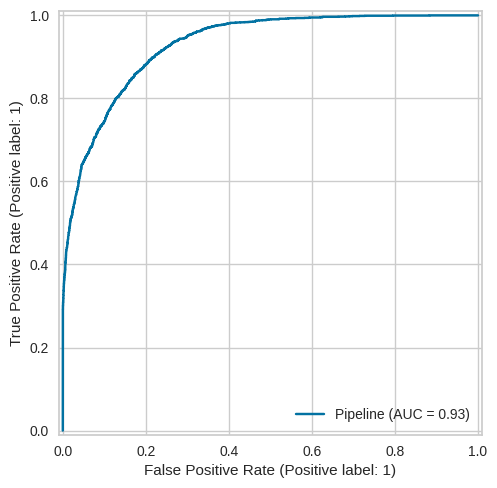

In [91]:
RocCurveDisplay.from_estimator(xgb_pipeline, x_test, y_test);

### Tunning des hyperparamètres

In [41]:
from scipy.stats import randint, uniform

xgb_param_grid = {
    "clf__n_estimators": randint(100, 300),          # nombre d'arbres
    "clf__max_depth": [3, 6, 10],                    # profondeur max de chaque arbre
    "clf__learning_rate": uniform(0.01, 0.2),        # taux d'apprentissage
    "clf__subsample": [0.6, 0.8, 1.0],               # échantillonage sur les lignes
    "clf__colsample_bytree": [0.6, 0.8, 1.0],        # échantillonage sur les colonnes
    "clf__gamma": [0, 0.1, 0.2],                     # gain minimal pour un split
    "clf__min_child_weight": [1, 5, 10]              # nombre minimal d'exemples dans un noeud
}


In [42]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scipy.stats import randint, uniform

# Validation croisée
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Recherche aléatoire
xgb_random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=xgb_param_grid,
    n_iter=20,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Entraînement
xgb_random_search.fit(x_train, y_train)

# Meilleurs hyperparamètres
logger.info(f"Best parameters: {xgb_random_search.best_params_}")

# Prédictions
xgb_y_pred = xgb_random_search.predict(x_test)
xgb_y_proba = xgb_random_search.predict_proba(x_test)[:, 1]

# Évaluation
logger.info(f"AUC: {roc_auc_score(y_test, xgb_y_proba):.2f}")
logger.info(f"F1-score: {f1_score(y_test, xgb_y_pred):.2f}")
logger.info(f"Accuracy: {accuracy_score(y_test, xgb_y_pred):.2f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\user\OneDrive\Desktop\ENSAE\Semestre 2\IML2\Tp_classification\tp-supervised-learning\.env\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:41:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2025-05-06 15:41:14.153 | INFO     | __main__:<module>:23 - Best parameters: {'clf__colsample_bytree': 0.6, 'clf__gamma': 0.1, 'clf__learning_rate': np.float64(0.2030510614528276), 'clf__max_depth': 3, 'clf__min_child_weight': 1, 'clf__n_estimators': 256, 'clf__subsample': 1.0}
2025-05-06 15:41:14.488 | INFO     | __main__:<module>:30 - AUC: 0.93
2025-05-06 15:41:14.498 | INFO     | __main__:<module>:31 - F1-score: 0.72
2025-05-06 15:41:14.503 | INFO     | __main__:<module>:32 - Accuracy: 0.87


In [107]:
viz = DiscriminationThreshold(xgb_random_search.best_estimator_, random_state=42, fbeta=1.0, cv=cv, argmax="fscore")

# Fit et plot
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.show();

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[23:18:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[23:18:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[23:18:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[23:18:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[23:18:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[23:18:32] WARNING: /workspace

In [108]:
data_lift = pd.DataFrame({"y_true": y_test, "y_pred": xgb_y_pred, "proba": xgb_y_proba})
data_lift = data_lift.sort_values("proba", ascending=False).reset_index(drop=True)
data_lift.head()

y_true  y_pred     proba
0       1       1  0.999872
1       1       1  0.999851
2       1       1  0.999826
3       1       1  0.999822
4       1       1  0.999786

In [110]:
data_lift["decile"] = pd.qcut(data_lift.index, 10, labels=False)
data_lift.head()

y_true  y_pred     proba  decile
0       1       1  0.992177       0
1       1       1  0.992170       0
2       1       1  0.992169       0
3       1       1  0.991474       0
4       1       1  0.991247       0

In [94]:
ConfusionMatrixDisplay.from_estimator(xgb_random_search, x_test, y_test,
                                      display_labels=["<=50K", ">50K"],
                                      normalize="true", cmap=plt.cm.Blues);

In [95]:
RocCurveDisplay.from_estimator(xgb_random_search, x_test, y_test);

## Choix du modèle final

Parmi les modèles testés, ***`XGBoost`*** présente les meilleures performances en termes de F1-score et AUC. Malgré un temps de calcul plus élevé, il est retenu pour sa capacité à bien classer les observations dans un contexte de déséquilibre de **classes**

## Importance des features avec Shap

In [96]:
pip install shap

In [43]:
import shap


c:\Users\user\OneDrive\Desktop\ENSAE\Semestre 2\IML2\Tp_classification\tp-supervised-learning\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [44]:
# Extraction du meilleur pipeline
best_pipeline = xgb_random_search.best_estimator_

# Extraction du modèle XGBoost pur
xgb_model = best_pipeline.named_steps["clf"]



### Importance globale des features

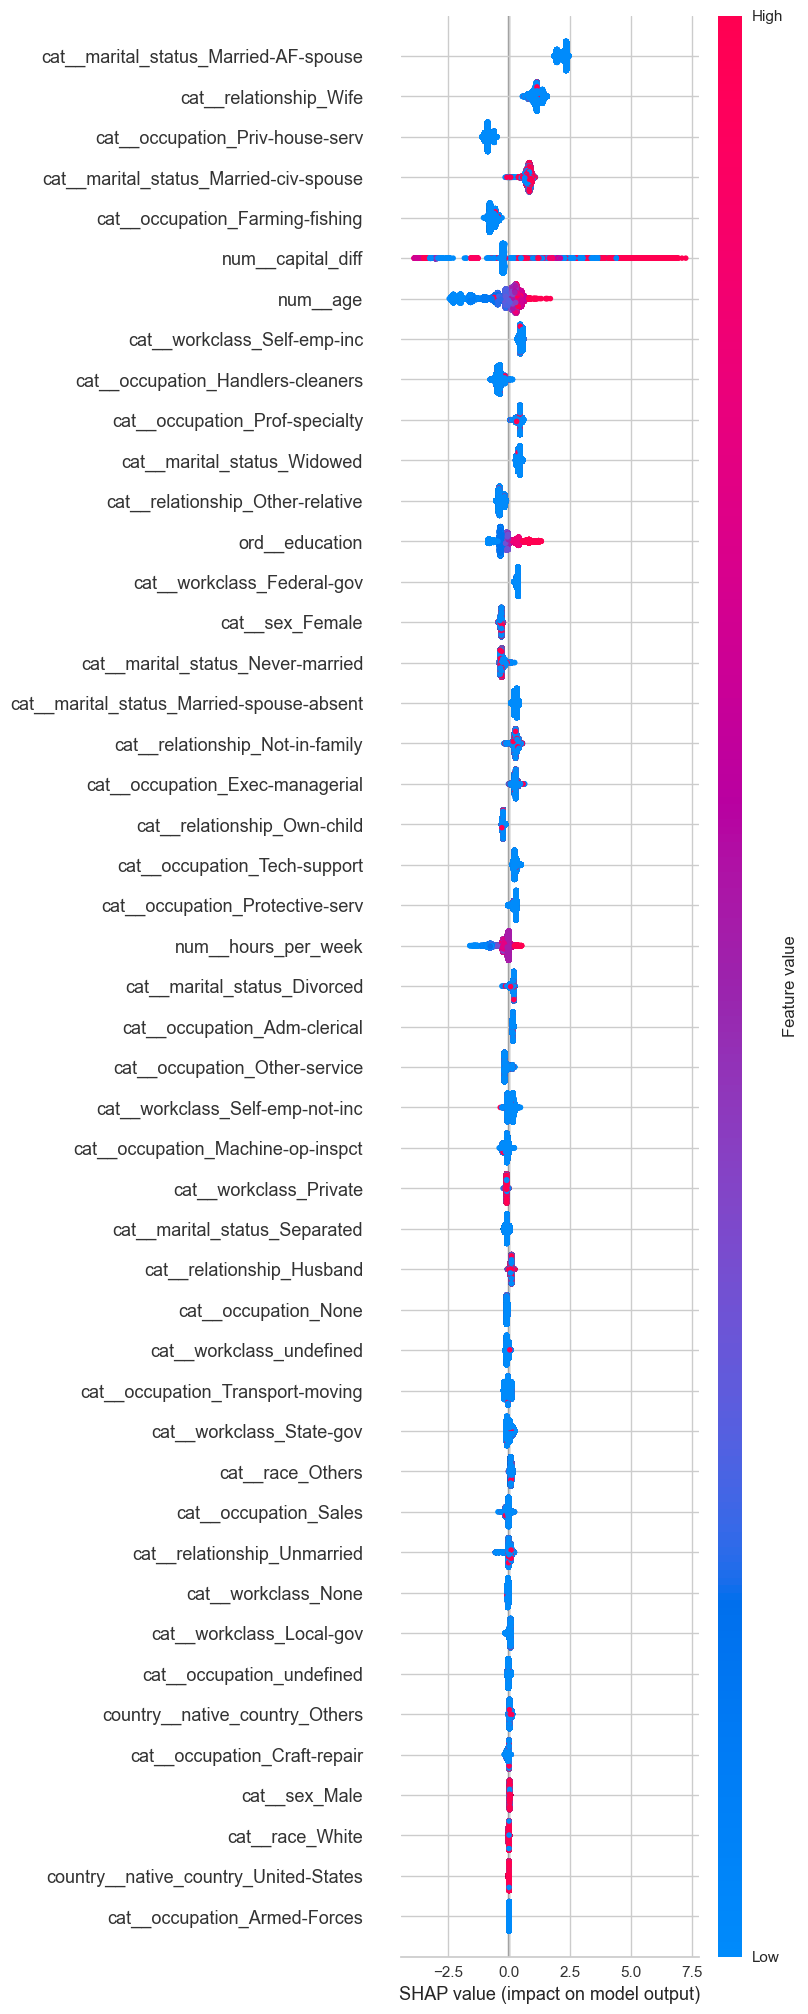

In [45]:
import shap
import pandas as pd

# 1. Extraire le meilleur modèle XGBoost depuis le pipeline
xgb_model = xgb_random_search.best_estimator_.named_steps["clf"]

# 2. Extraire les données transformées
preprocessor = xgb_random_search.best_estimator_.named_steps["preprocessor"]
X_transformed = preprocessor.transform(x_train)
feature_names = preprocessor.get_feature_names_out()

# 3. Créer DataFrame avec noms de colonnes
X_transformed_df = pd.DataFrame(X_transformed.toarray(), columns=feature_names)

# 4. Utiliser TreeExplainer (recommandé pour XGBoost)
explainer = shap.TreeExplainer(xgb_model)

# 5. Calculer les valeurs SHAP
shap_values = explainer.shap_values(X_transformed_df)

# 6. Visualisation avec max_display et couleurs
shap.summary_plot(shap_values, X_transformed_df, plot_type="dot", max_display=50)


In [100]:
shap.summary_plot(shap_values, X_transformed_df, plot_type="bar")


### Interpretation

Ce graphique présente l’influence des différentes variables sur les prédictions d’un modèle XGBoost, pour une tâche de classification du revenu (probablement prédire s’il est >50K ou non). Il s'agit d'une SHAP summary plot, qui permet de visualiser à la fois l’importance des variables et la direction de leur effet.

Les variables les plus importantes pour le modèle sont en haut, notamment cat__marital_status_Married-AF-spouse, num__capital_diff, et num__age.

Quand une variable est rouge (valeur élevée) et vers la droite (SHAP > 0), cela signifie qu’elle augmente la probabilité d’un revenu élevé.

À l’inverse, une valeur bleue (valeur faible) vers la gauche (SHAP < 0) signifie qu’elle pousse vers un revenu faible.

Le statut marital est extrêmement discriminant : certaines catégories comme "Married-AF-spouse" influencent fortement positivement le revenu.

Le capital_diff (différence entre capital gains et losses) est un indicateur majeur : un capital positif élevé tire la prédiction vers un revenu élevé.

L’âge a également un effet net : les personnes plus âgées (en rouge) ont plus de chances d’avoir un revenu élevé.

Certaines professions comme "Exec-managerial" ou "Prof-specialty" sont liées à des revenus élevés, tandis que d'autres (ex. : "Handlers-cleaners") sont liées à des revenus faibles.

D'autres variables comme la race ou certaines origines géographiques ont un effet beaucoup plus limité sur la prédiction.

Globalement, le modèle utilise surtout des indicateurs socio-économiques (capital, emploi, âge, statut marital) pour prédire le revenu.

Ce graphique permet de conclure que le modèle est cohérent : il s’appuie sur des variables logiques, en leur attribuant des poids bien interprétables.

### Importance locale des features pour les 10 premières observations

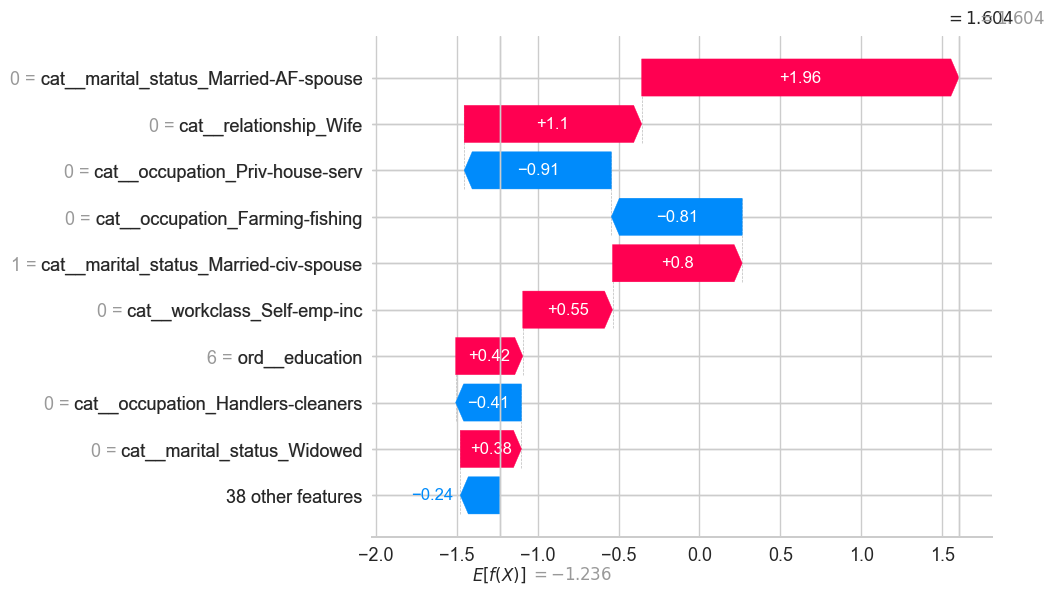

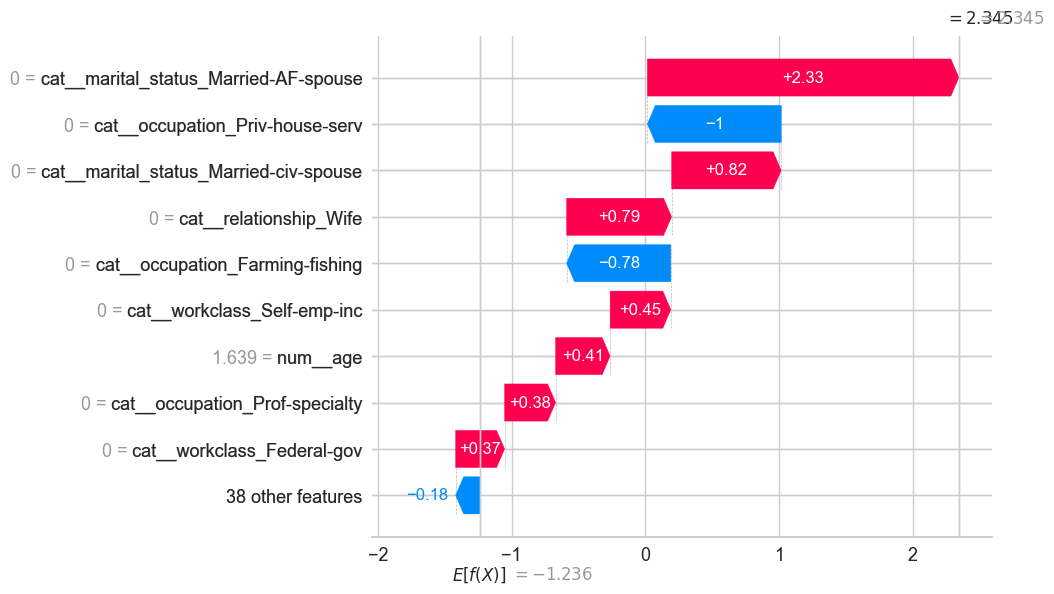

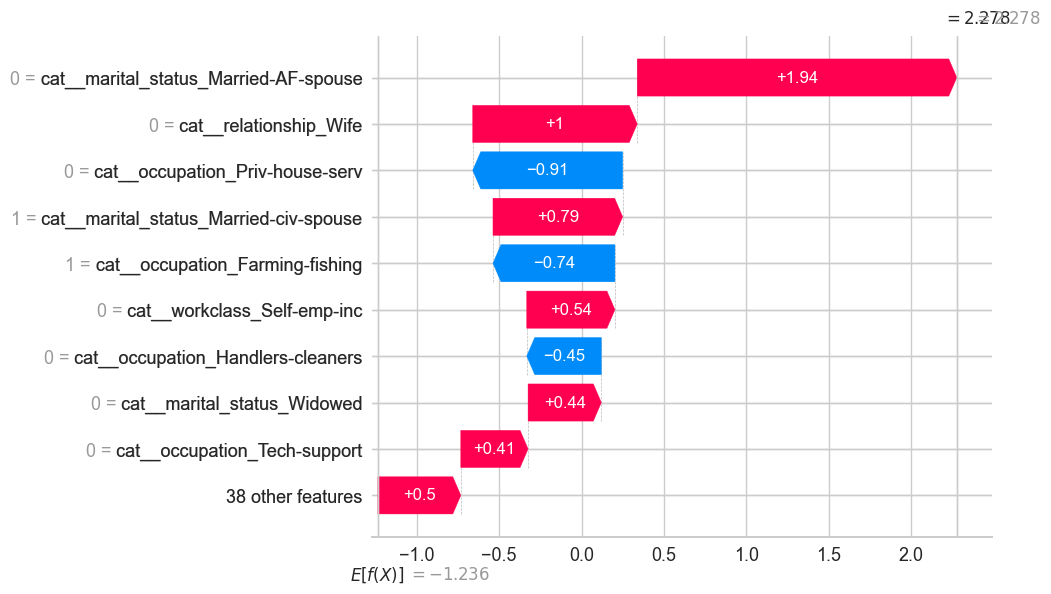

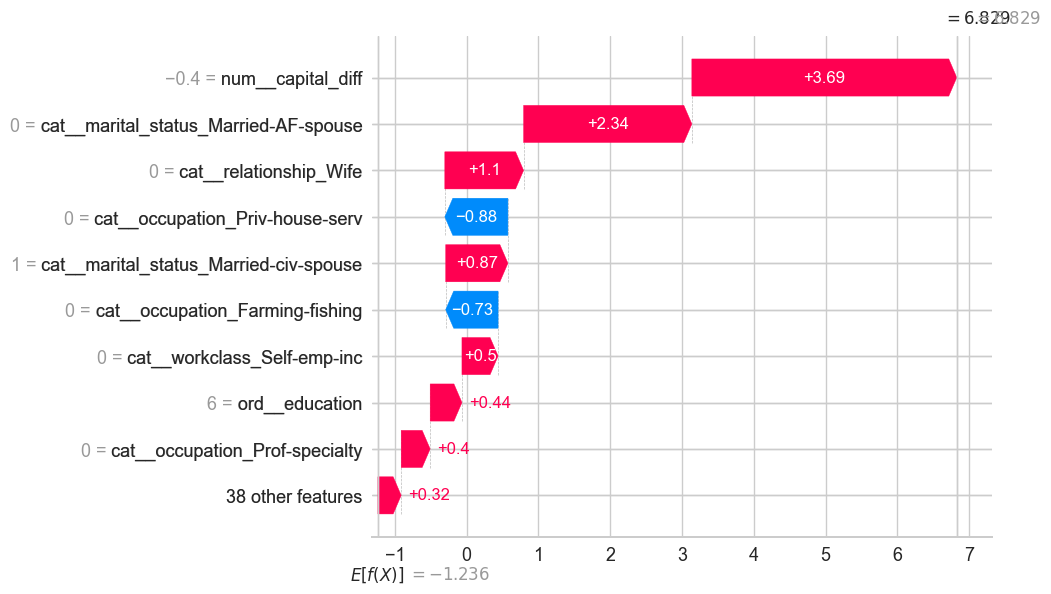

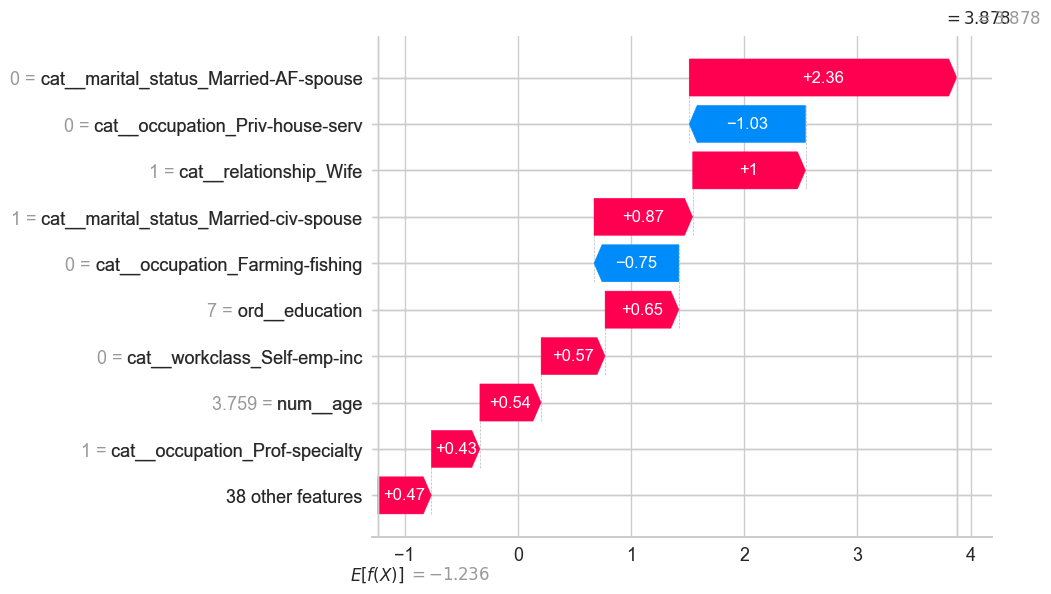

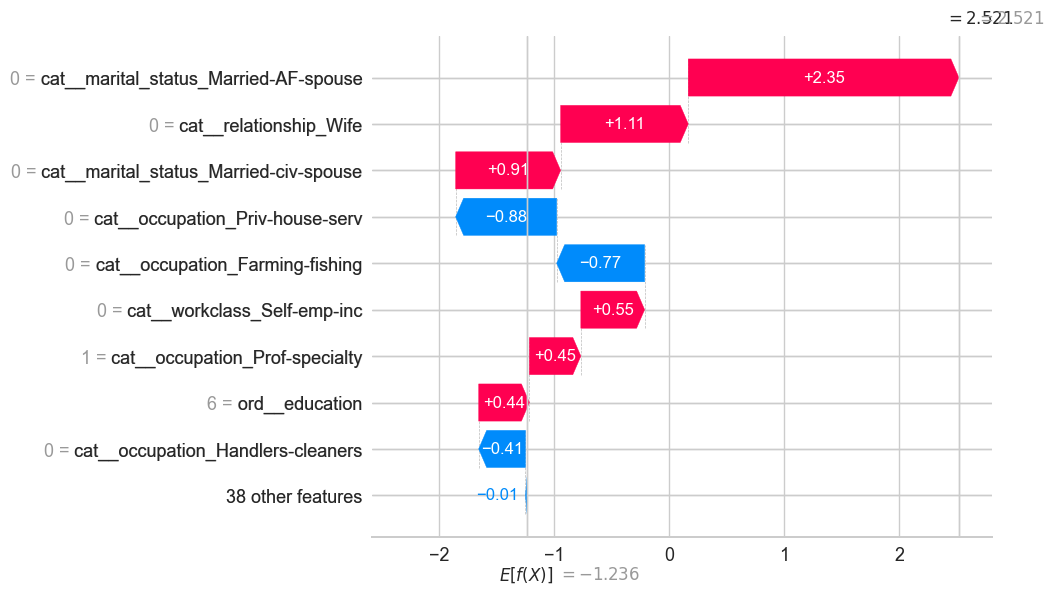

In [46]:
for i in range (10):

  sample = X_transformed_df.iloc[:10]
  shap_values = explainer(sample)

  shap.plots.waterfall(shap_values[i])

### Interprétation des résultats

Le graphique ci-dessus présente l'importance locale des variables pour les 10 premières observations du jeu de données. Chaque barre représente l'impact d'une variable sur la prédiction du modèle pour une observation donnée.
E[f(X)]=−1.236, correspond au log-odds moyen de la classe cible (revenu élevé).

À partir de cette base, chaque variable ajoute ou retire un effet à la prédiction finale, qui est ici 

f(x)=1.604, donc une forte probabilité de revenu élevé.

La variable la plus influente est cat__marital_status_Married-AF-spouse, qui augmente fortement la prédiction (+1.96).

Le fait que la personne soit dans une relation Wife, Married-civ-spouse, et qu’elle ait une éducation élevée (niveau 6) contribue aussi positivement à la prédiction.

D’autres facteurs comme workclass_Self-emp-inc (travailleur indépendant à revenus élevés) soutiennent également la probabilité d’un bon revenu.

En revanche, le fait d’avoir une occupation dans le secteur privé à domicile, ou dans le domaine Farming-fishing, tire la prédiction vers le bas.

Les métiers de type Handlers-cleaners ou le statut Widowed ont aussi des effets légèrement négatifs.

La barre bleue "38 other features" indique que la majorité des autres variables ont un effet cumulé négatif léger (-0.24), donc peu d'impact global.

Les couleurs : rouge = contribution positive, bleu = contribution négative.

Conclusion : ce graphique montre que le modèle s’appuie fortement sur le statut marital, le niveau d'éducation et le type d'emploi pour prédire un revenu élevé pour cet individu.

## Enregistrement du modèle

#### Nous n'aurons pas besoin d'optimiser encore le modèle, car il est déjà très performant. Nous allons donc l'enregistrer au format `.dill` pour une utilisation ultérieure.

In [101]:
pip install dill

In [111]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [112]:
import os
import dill

# Spécifie le chemin complet pour le modèle
model_path = '/content/drive/MyDrive/Colab Notebook/models/xgb_final_model1.dill'

# Créer le dossier 'models' si il n'existe pas
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Enregistrer le modèle XGBoost
with open(model_path, 'wb') as f:
    dill.dump(xgb_random_search.best_estimator_, f)

print(f"Modèle sauvegardé à : {model_path}")

Modèle sauvegardé à : /content/drive/MyDrive/Colab Notebook/models/xgb_final_model1.dill
